In [16]:
pip install mne hu-neuro-pipeline  

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
    --------------------------------------- 0.3/11.0 MB ? eta -:--:--
   -- ------------------------------------- 0.8/11.0 MB 2.6 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/11.0 MB 2.6 MB/s eta 0:00:04
   -------- ------------------------------- 2.4/11.0 MB 2.9 MB/s eta 0:00:04
   --------- ------------------------------ 2.6/11.0 MB 2.5 MB/s eta 0:00:04
   ---------- ----------------------------- 2.9/11.0 MB 2.6 MB/s eta 0:00:04
   ----------------- ---------------------- 4.7/11.0 MB 3.3 MB/s eta 0:00:02
   -------------------- ------------------- 5.8/11.0 MB 3.6 MB/s eta 0:00:02
   ------------------------ --------------- 6.8/11.0 MB 3.7 MB/s eta 0:00:02
   ---------------------------- ----------- 7.9/11.0 MB 3.7 MB/s eta 0:00:01
   -------------------------------- ------- 8.9/11.0 MB 3.9 MB/s eta 0:00:01
   ---------------------------------- ----- 9.4/11.0 MB 3.9 MB/s eta 0:00:01
   ----------

In [17]:
import numpy as np
import pandas as pd
import json

import matplotlib.pyplot as plt
from mne import set_bipolar_reference
from mne.io import read_raw
from mne.preprocessing import ICA
from pipeline.datasets import get_erpcore
from mne import (Epochs, events_from_annotations, merge_events)
from mne.viz import plot_compare_evokeds

## Set de datos
Los datos provienen del paper de Kappenman et al 2021. Contiene 6 experimentos sensillos de EEG que estan diseñados para estudiar ERPs conocidos. Contienen información de 6 experimentos.


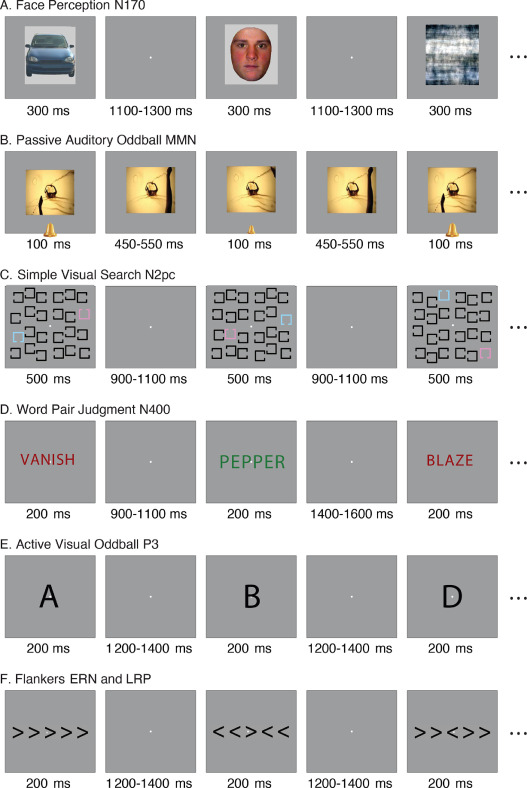


**El código para levantar los datos de los distintos protocolos:  'N170', 'MMN', 'N2pc', 'N400', 'P3', 'ERN'**

## Reconocimiento de caras N170

Vamos a visualizar los datos crudos de un sujetx (n=4)


In [20]:
files_dict = get_erpcore('N170', participants='sub-004', path='data')
files_dict

{'log_files': ['c:\\repos\\neuro_cognitiva\\practica_2\\data\\erpcore\\N170\\sub-004\\eeg\\sub-004_task-N170_events.tsv'],
 'raw_files': ['c:\\repos\\neuro_cognitiva\\practica_2\\data\\erpcore\\N170\\sub-004\\eeg\\sub-004_task-N170_eeg.set']}

# Carga datos crudos

Los datos crudos estan en formato .set y .fdt (formato eeglab de Matlab).
Generamos un objeto llamado **raw** que contiene los datos continuos y metadata

In [22]:
raw_file = files_dict['raw_files'][0]
raw = read_raw(raw_file, preload=True)
raw

Reading c:\repos\neuro_cognitiva\practica_2\data\erpcore\N170\sub-004\eeg\sub-004_task-N170_eeg.fdt
Reading 0 ... 649215  =      0.000 ...   633.999 secs...


<RawEEGLAB | sub-004_task-N170_eeg.fdt, 33 x 649216 (634.0 s), ~163.5 MB, data loaded>

Podemos ver los datos en de array de numpy

In [24]:
data = raw.get_data()
data.shape

(33, 649216)

In [28]:
raw.get_data().shape

5.960464477539063e-08

De los 33 canales hay 3 canales que miden el movimiento de los ojos y pestañeos (VEOG, HEOG_right y HEOG_left).

Genero un canal de EOG que extraiga las señales más importante de los ojos (verticales EOG [VEOG] = diferencia entre arriba y abajo; horizontales EOG [HEOG] = difference entre izquierda y derecha). Explicitamente creamos canales del tipo **eog** y tiramos los caneles originales, quedando con 30 canales + 2 de eog.


In [29]:
# EOG: electrooculography; EEG: electroncefalography
raw = set_bipolar_reference(raw, anode='FP1', cathode='VEOG_lower',
                            ch_name='VEOG', drop_refs=False)
raw = set_bipolar_reference(raw, anode='HEOG_right', cathode='HEOG_left',
                            ch_name='HEOG', drop_refs=False)
raw = raw.set_channel_types({'VEOG': 'eog', 'HEOG': 'eog'})
raw = raw.drop_channels(['VEOG_lower', 'HEOG_right', 'HEOG_left'])

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=649216
    Range : 0 ... 649215 =      0.000 ...   633.999 secs
Ready.
Added the following bipolar channels:
VEOG
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=1, n_times=649216
    Range : 0 ... 649215 =      0.000 ...   633.999 secs
Ready.
Added the following bipolar channels:
HEOG


## Fijo el **montaje**

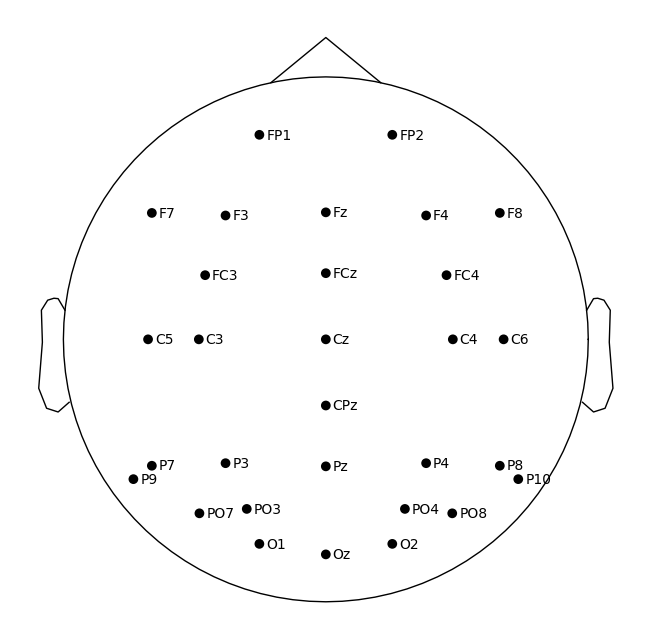

['FP1', 'F3', 'F7', 'FC3', 'C3', 'C5', 'P3', 'P7', 'P9', 'PO7', 'PO3', 'O1', 'Oz', 'Pz', 'CPz', 'FP2', 'Fz', 'F4', 'F8', 'FC4', 'FCz', 'Cz', 'C4', 'C6', 'P4', 'P8', 'P10', 'PO8', 'PO4', 'O2', 'VEOG', 'HEOG']


In [32]:
raw = raw.set_montage('biosemi64', match_case=False)
_ = raw.plot_sensors(show_names=True)
print(raw.ch_names[:])

## Grafico los datos

Using matplotlib as 2D backend.


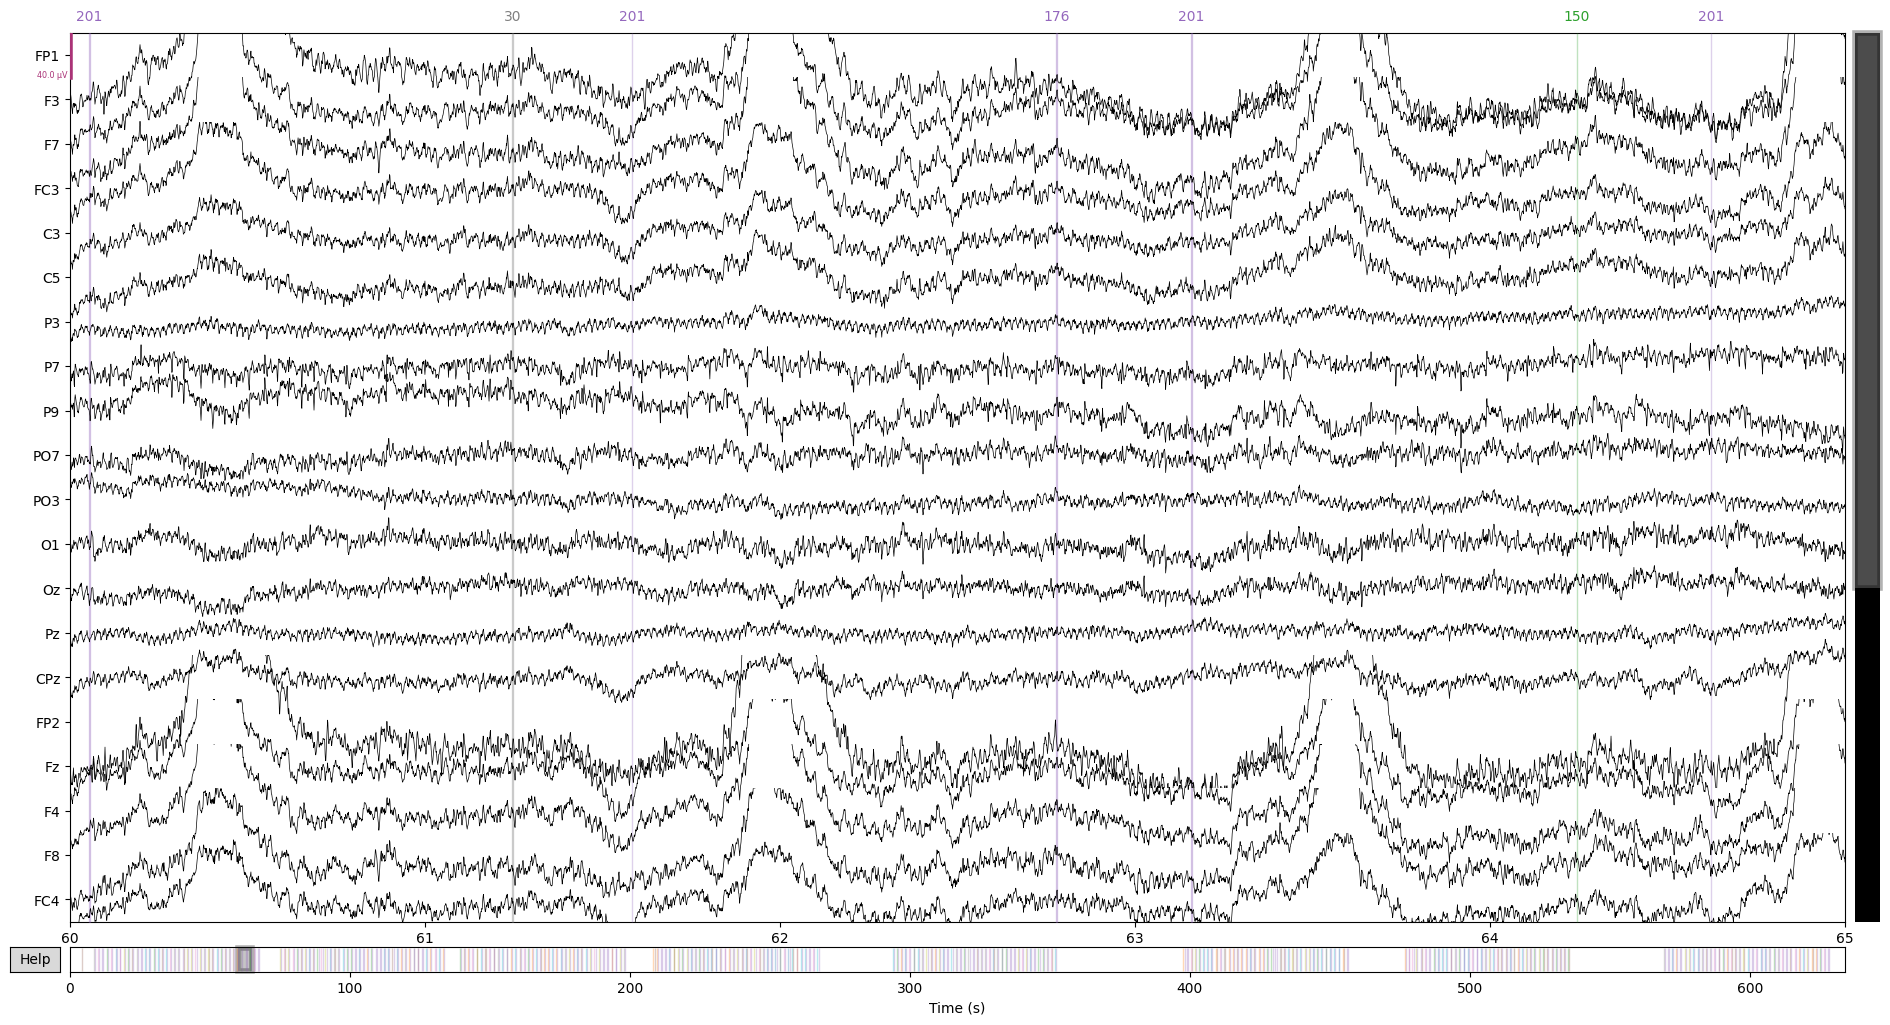

In [33]:
_ = raw.plot(start=60.0, duration=5) # Arranca a los 10s y 10 s de duración
# _ = raw.plot(start=10.0, duration=10.0,scalings={'eeg': 60e-6})

También se puede ver el espectro (power spectral density)

Effective window size : 2.000 (s)


Plotting power spectral density (dB=True).


c:\repos\neuro_cognitiva\.venv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


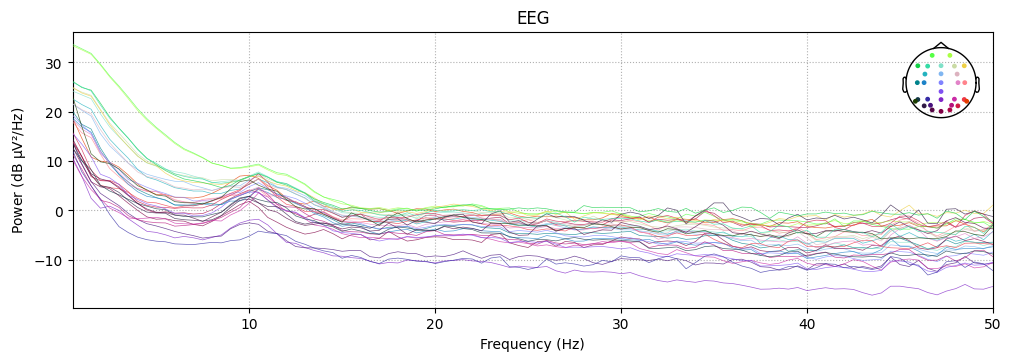

In [38]:
_=raw.compute_psd(fmin=0.1,fmax=50).plot()

# Preprocesado

## Filtros
Se filtra la señal con un pasabanda entre 0.1 y 40 Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)


- Filter length: 3381 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.3s


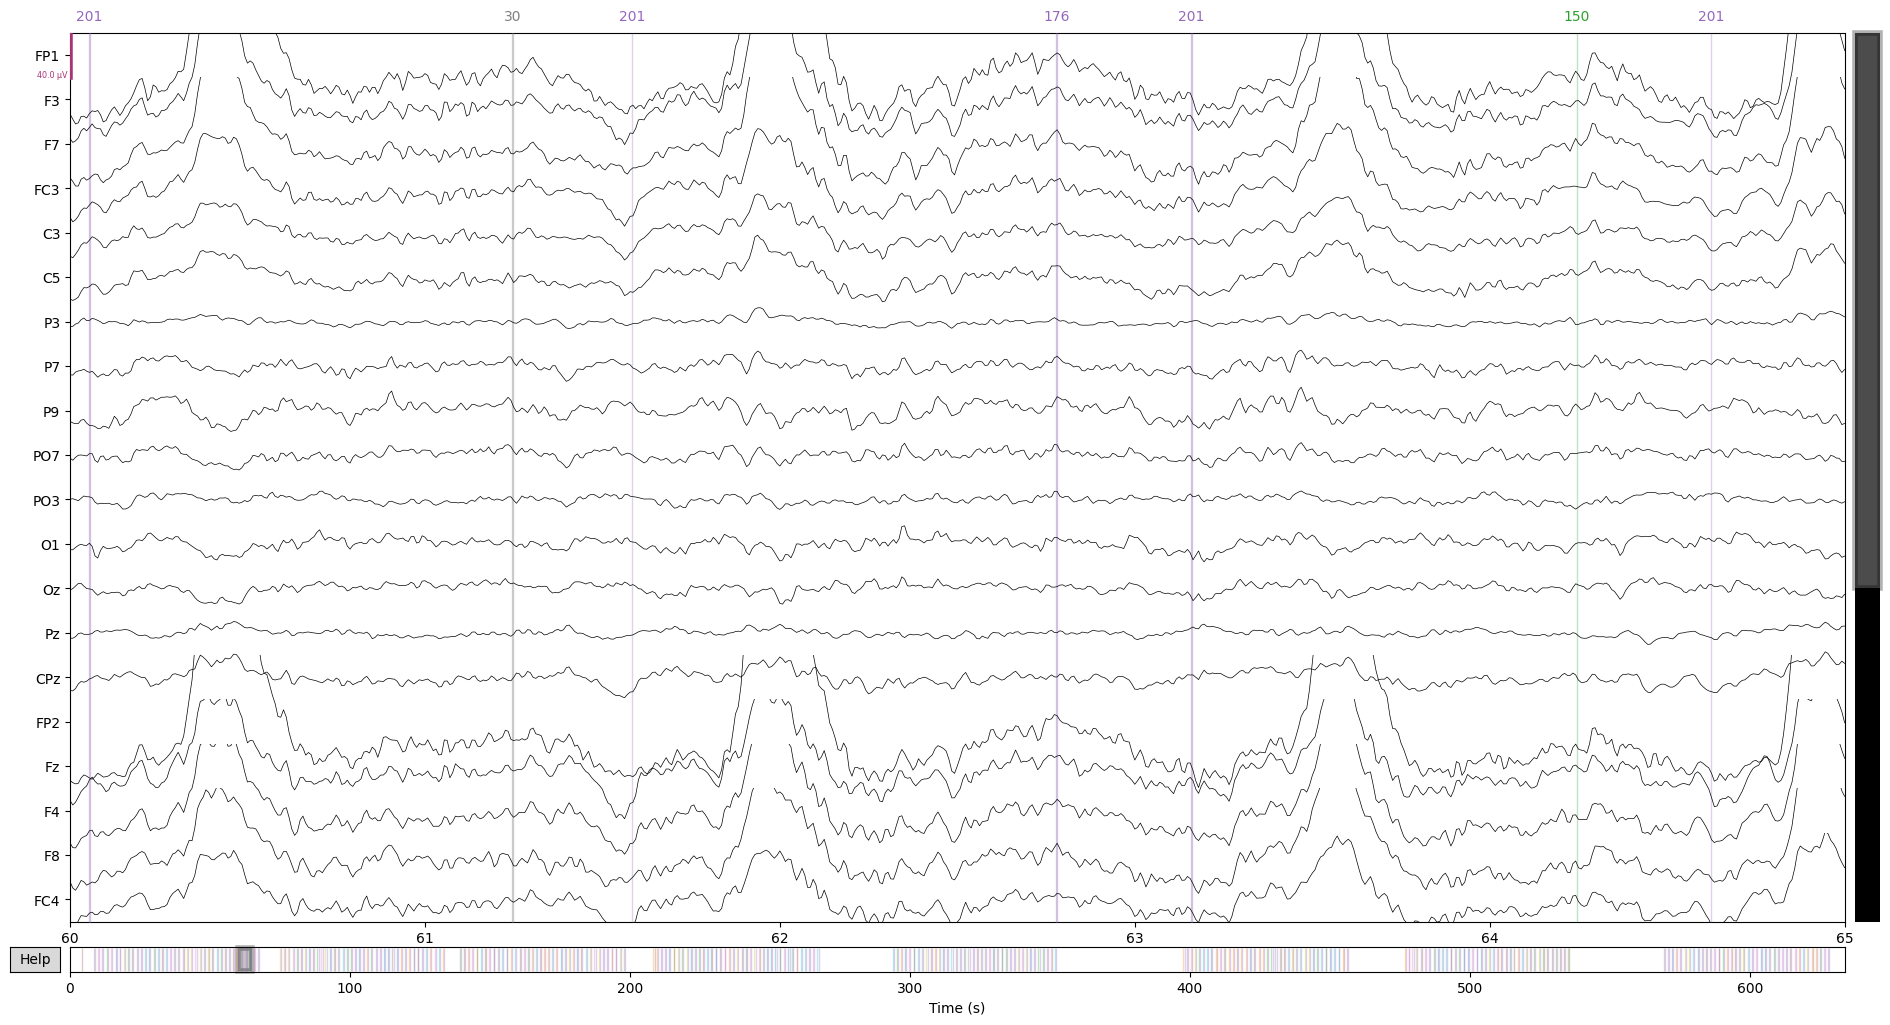

Effective window size : 2.000 (s)
Plotting power spectral density (dB=True).


c:\repos\neuro_cognitiva\.venv\lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


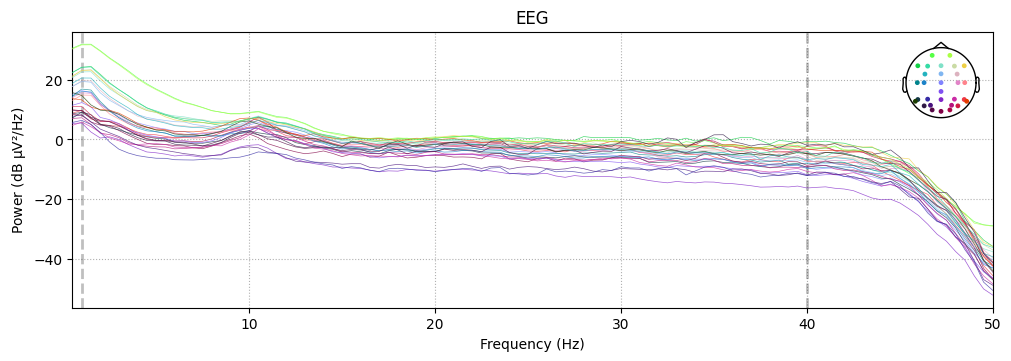

In [39]:
raw = raw.filter(l_freq=1, h_freq=40)
_ = raw.plot(start=60.0, duration=5.0)
_=raw.compute_psd(fmin=0.1,fmax=50).plot()

## Corregimos los artefactos oculares (ICA).

Para eliminar movimientos oculares se utiliza (en general) un Anális de Componentes Independientes (ICA).

Cada componente se caracteriza por un patrón espacial (topografía).

Fitting ICA to data using 30 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 40.8s.


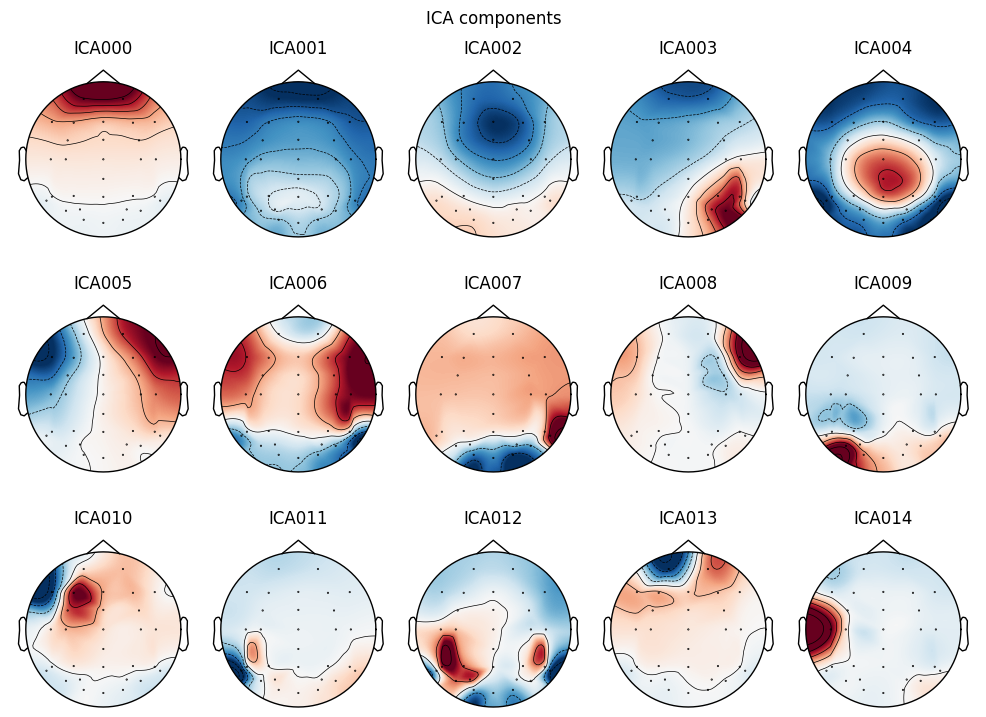

In [40]:
ica = ICA(n_components=15)
ica = ica.fit(raw)
_ = ica.plot_components()

También se puede extraer, según indices que los **eog** cuáles son las componentes que representan movimientos oculares

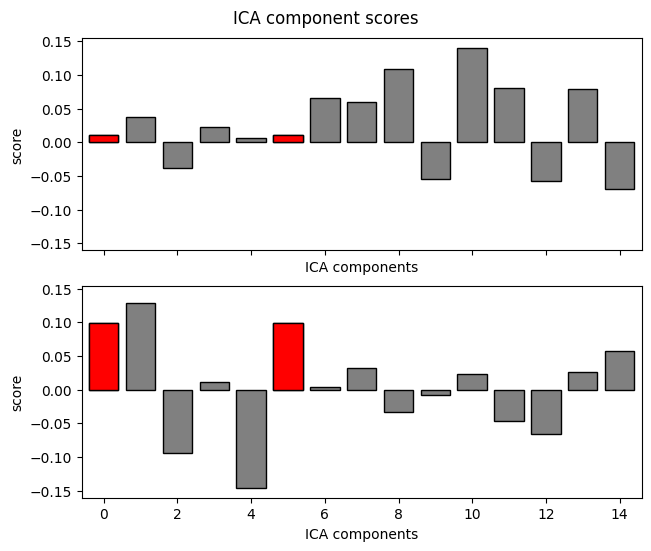

In [62]:
eog_indices, eog_scores = ica.find_bads_eog(raw, ch_name=['HEOG', 'VEOG'],
                                            verbose=False)
ica.exclude = eog_indices
_ = ica.plot_scores(eog_scores)


Tengo que la 0 y la 5 son componentes oculares, entonces las saco y me fijo cómo queda la señal.

Applying ICA to Raw instance


    Transforming to ICA space (15 components)
    Zeroing out 2 ICA components
    Projecting back using 30 PCA components


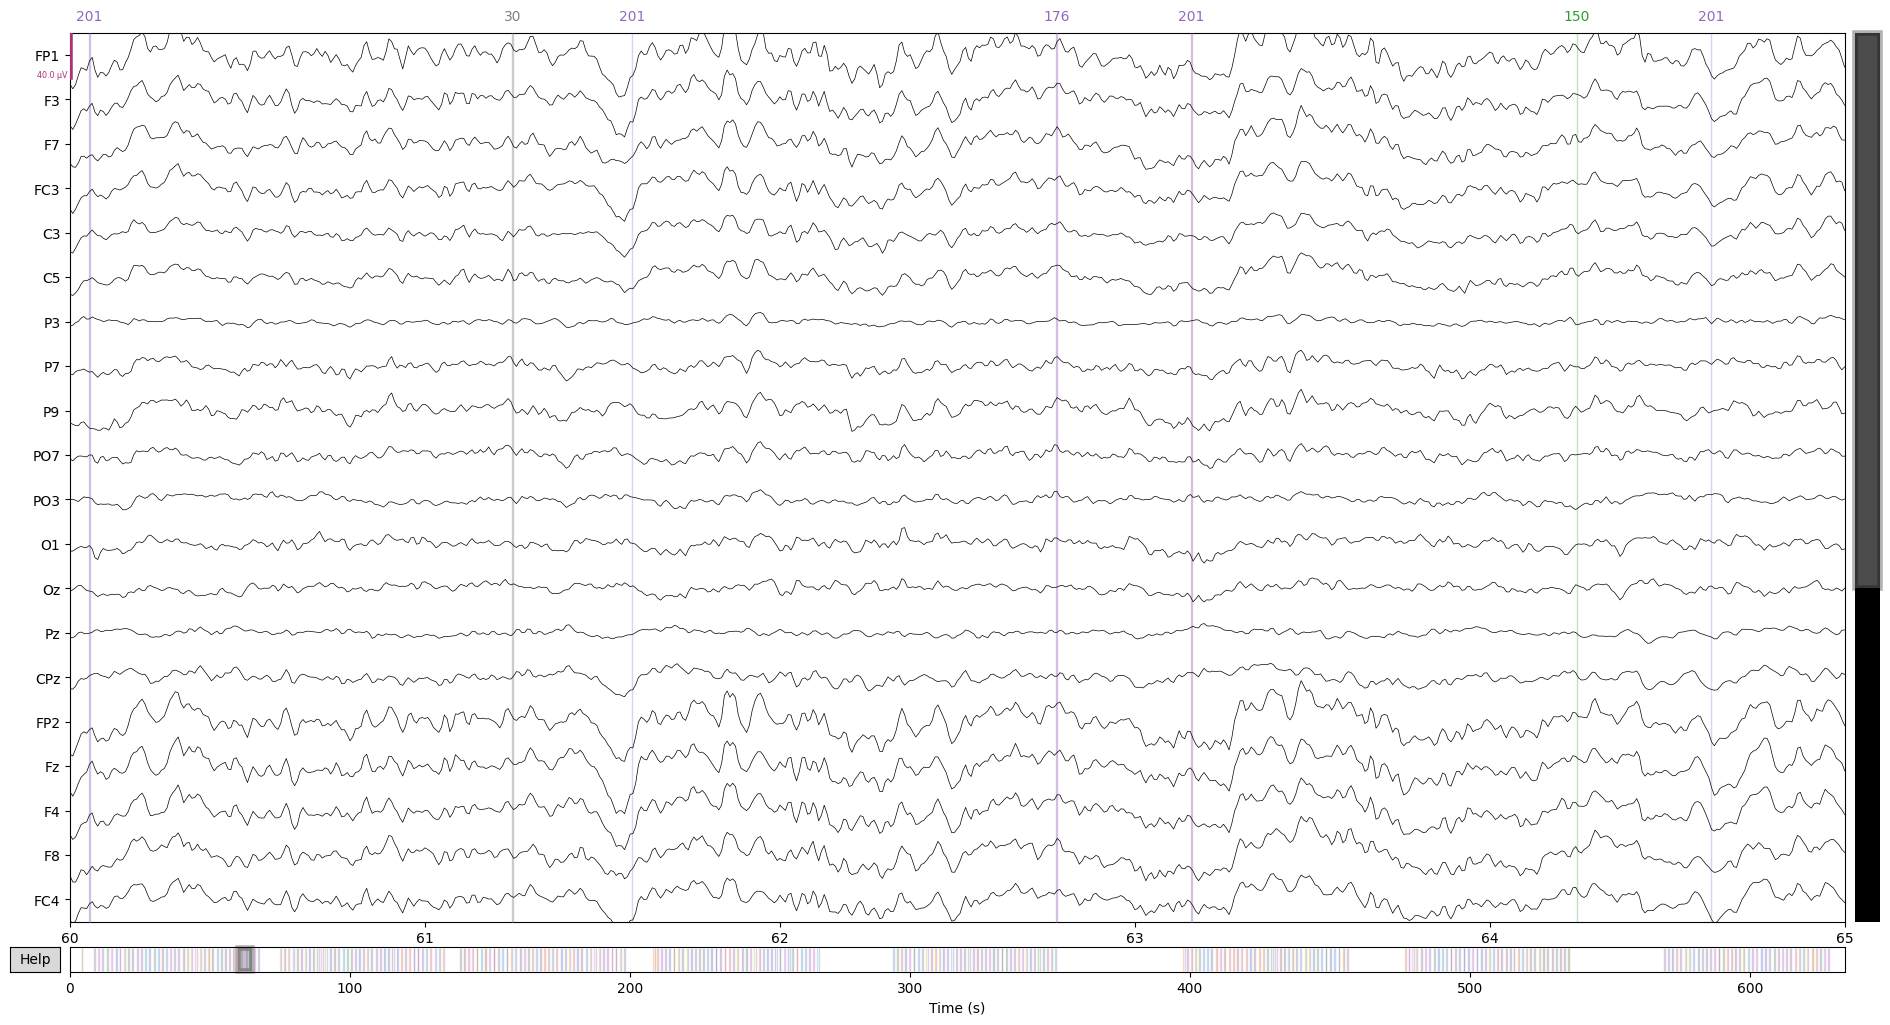

In [43]:
raw = ica.apply(raw)
_ = raw.plot(start=60.0, duration=5.0)

## Re-referencia

De forma offline se suele referenciar los datos a una señal con poco ruido, compo el promedio de los canales.

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


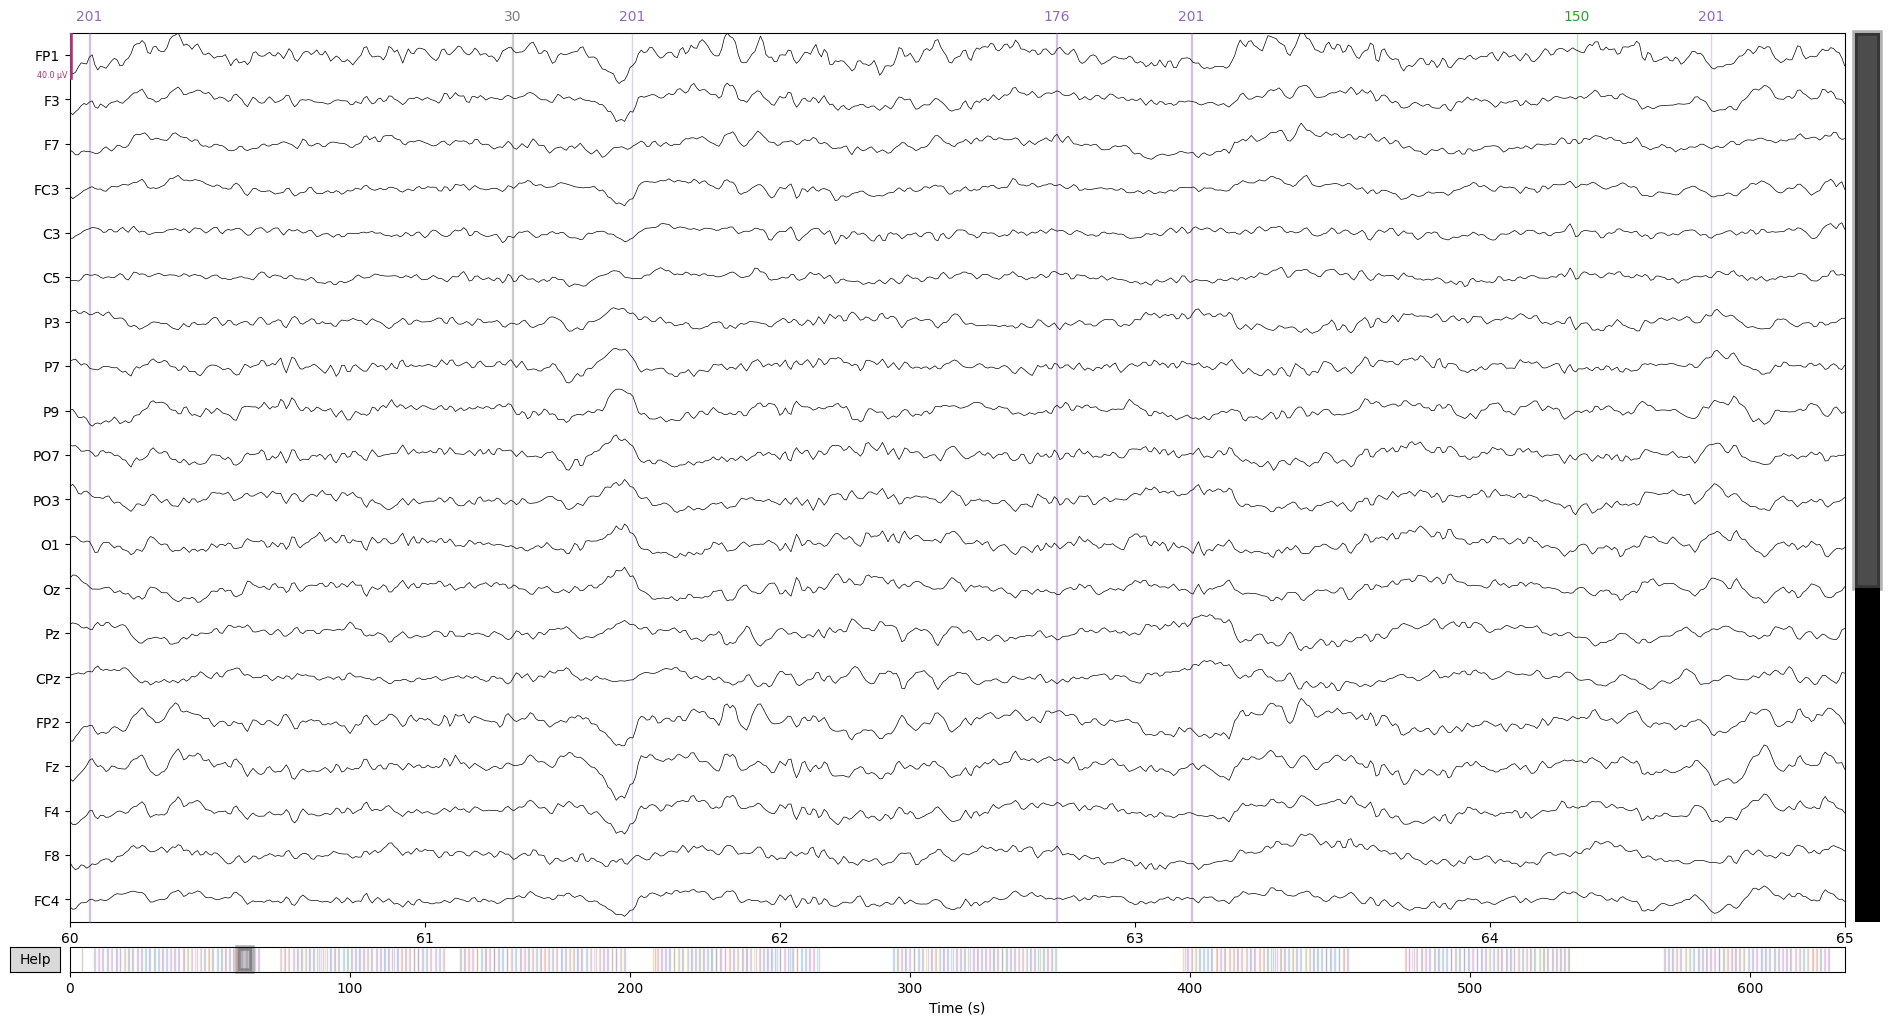

In [45]:
raw = raw.set_eeg_reference('average')
_ = raw.plot(start=60.0, duration=5.0)

# Segmentación

En general no interesa los datos continuos, sino centrarnos alrededor del evento o eventos de interés (en el onset o offset del estímulo dependiendo de la pregunta).

Los eventos se guardan como marcas, código numérico.

In [80]:
# %pycat data/erpcore/N170/task-N170_events.json #Información de los eventos
with open('data/erpcore/N170/task-N170_events.json') as f:
    d = json.load(f)
    print(d)

{'value': {'LongName': 'Event code value', 'Levels': {'1-40': 'Stimulus - faces', '41-80': 'Stimulus - cars', '101-140': 'Stimulus - scrambled faces', '141-180': 'Stimulus - scrambled cars', '201': 'Response - correct', '202': 'Response - error'}}}


In [77]:
events, event_id = events_from_annotations(raw)
print(events) # sample, duración, código del evento
print(len(event_id))

Used Annotations descriptions: ['1', '10', '101', '102', '103', '104', '105', '106', '107', '108', '109', '11', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '12', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '13', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '14', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '15', '150', '151', '152', '153', '154', '155', '156', '157', '158', '159', '16', '160', '161', '162', '163', '164', '165', '166', '167', '168', '169', '17', '170', '171', '172', '173', '174', '175', '176', '177', '178', '179', '18', '180', '19', '2', '20', '201', '202', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '6', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '7',

También se puede hacer desde un archivo externo


log_file = files_dict['log_files'][0];
log = pd.read_csv(log_file, sep='\t');
events = log[['sample', 'duration', 'value']].values.astype(int)


Dos tipos de eventos
Caras (1--40) y
Autos (41--80)


In [82]:
events = merge_events(events, ids=range(1, 41), new_id=1)
events = merge_events(events, ids=range(41, 81), new_id=2)
event_id = {'face': 1, 'car': 2}

(641, 3)

## Cortar las épocas

Ventanas de 1s, empezando 200 ms antes del onset del evento. Usamos como baseline los primeros 200 ms.

In [50]:
epochs = Epochs(raw, events, event_id, tmin=-0.2, tmax=0.8, baseline=(-0.2,0))


Not setting metadata
160 matching events found


Applying baseline correction (mode: mean)
0 projection items activated


Cambia las dimensiones, se agrega una mas, cambian los tiempos

In [51]:
epochs.get_data().shape

Using data from preloaded Raw for 160 events and 1025 original time points ...
0 bad epochs dropped


(160, 32, 1025)

Using data from preloaded Raw for 20 events and 1025 original time points ...


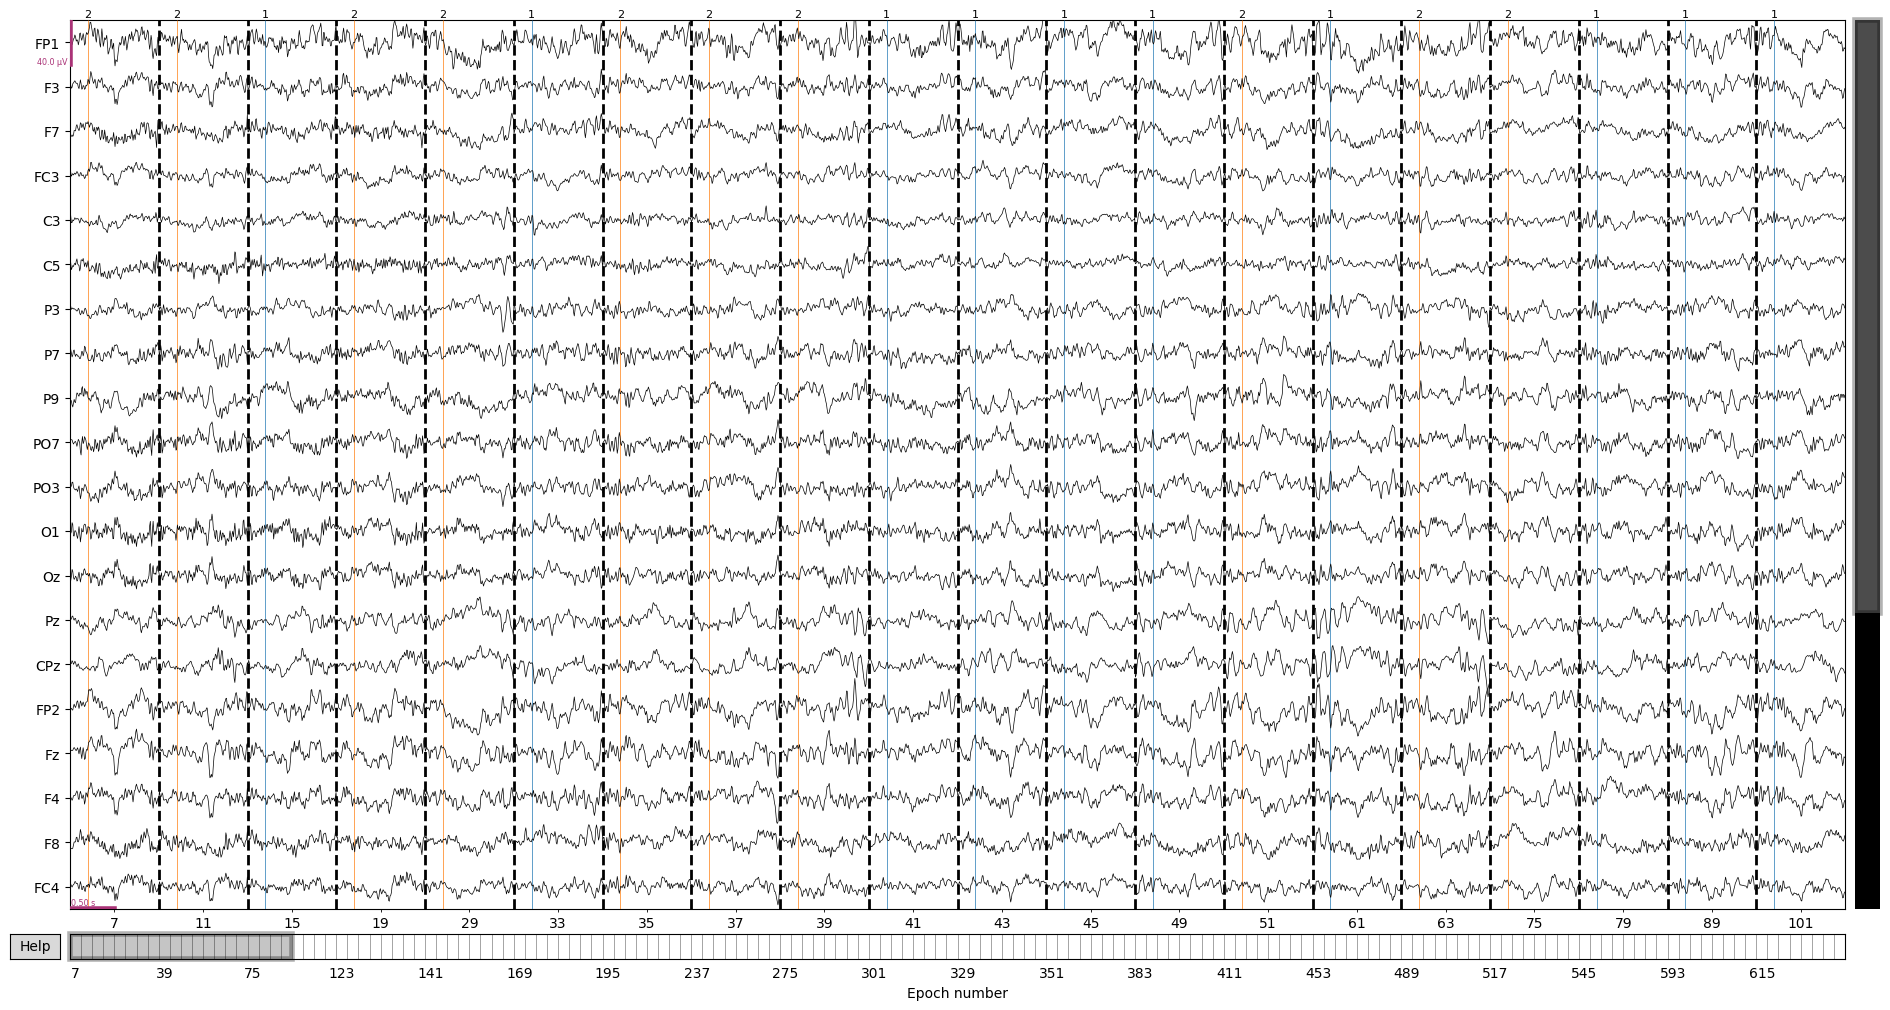

In [52]:

_ = epochs.plot(events=True)

Using data from preloaded Raw for 160 events and 1025 original time points ...


Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated


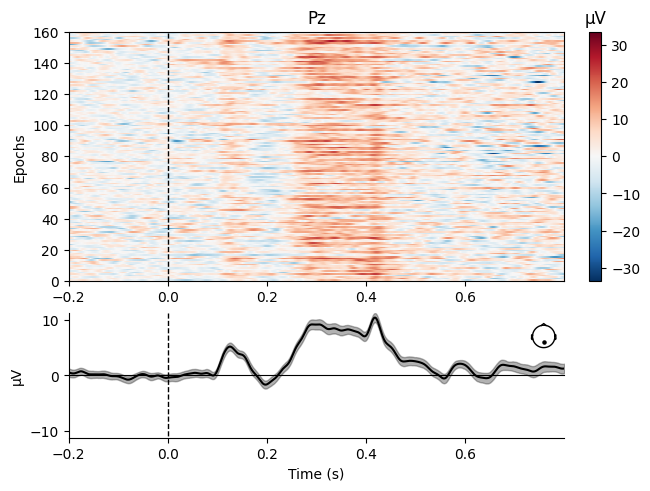

In [53]:
_ = epochs.plot_image(picks='Pz')

# Sacamos épocas malas

Podemos sacar epocas que tengan un  $V_{pp}>100 \mu V$

Using data from preloaded Raw for 158 events and 1025 original time points ...
0 bad epochs dropped
Using data from preloaded Raw for 158 events and 1025 original time points ...
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated


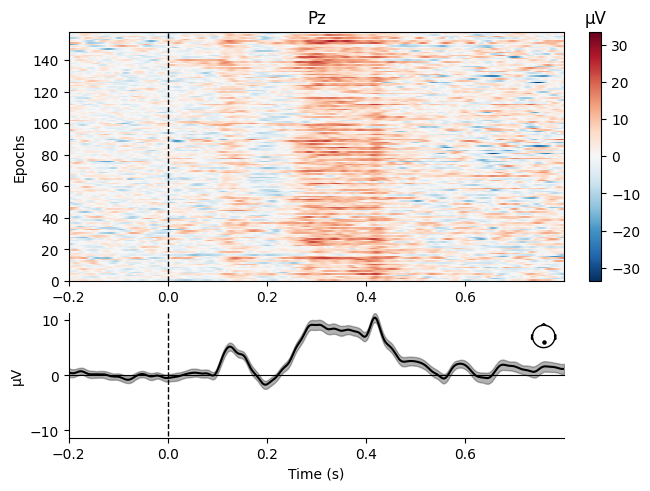

In [85]:
epochs = epochs.drop_bad({'eeg': 100e-6})

_ = epochs.plot_image(picks='Pz')

## Agrupo por condiciones



In [55]:
#epochs

In [56]:
evokeds_car = epochs['car'].average()
evokeds_car.comment = 'car'
#evokeds_car

In [27]:
evokeds_face = epochs['face'].average()
evokeds_face.comment = 'face'
#evokeds_face

<Evoked | 'face' (average, N=78), -0.2002 – 0.7998 s, baseline -0.2 – 0 s, 30 ch, ~287 kB>

In [84]:
evokeds_list = [evokeds_face, evokeds_car]
_ = plot_compare_evokeds(evokeds_list, picks='Pz')

NameError: name 'evokeds_face' is not defined

También se puede hacer a partir de los datos


Using data from preloaded Raw for 78 events and 1025 original time points ...
Using data from preloaded Raw for 80 events and 1025 original time points ...


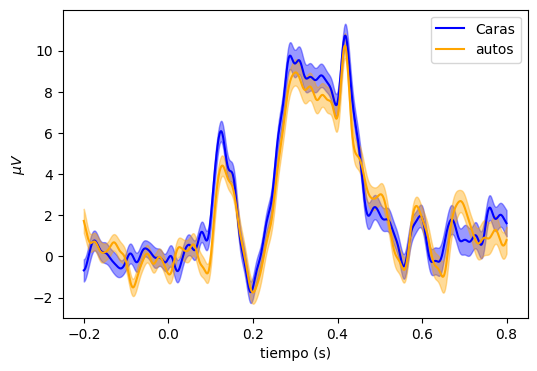

In [57]:
tiempo = epochs.times
caras = epochs['face'].get_data()/1e-6
autos = epochs['car'].get_data()/1e-6
ch_interest= 13 #Pz

y1=np.mean(caras,0)[ch_interest,:]
y1L = y1-np.std(caras,axis=0)/np.sqrt(caras.shape[0])
y1H = y1+np.std(caras,axis=0)/np.sqrt(caras.shape[0])
y2=np.mean(autos,0)[ch_interest,:]
y2L = y2-np.std(autos,axis=0)/np.sqrt(autos.shape[0])
y2H = y2+np.std(autos,axis=0)/np.sqrt(autos.shape[0])

plt.figure(figsize=(6,4))
plt.plot(tiempo,y1,c='b',label='Caras')
plt.fill_between(tiempo,y1L[ch_interest,:],y1H[ch_interest,:],color='b',alpha=0.4 )
plt.plot(tiempo,y2,c='orange',label='autos')
plt.fill_between(tiempo,y2L[ch_interest,:],y2H[ch_interest,:],color='orange',alpha=0.4 )
plt.xlabel('tiempo (s)')
plt.ylabel(r'$\mu V$')
plt.legend()


# Análisis tiempo frecuencia

In [58]:
freqs = np.logspace(*np.log10([4, 30]), num=8)
power_car, itc = epochs['car'].compute_tfr(
    method="morlet",
    freqs=freqs,
    n_cycles=2,
    average=True,
    return_itc=True,
    decim=3,
)

power_face, itc = epochs['face'].compute_tfr(
    method="morlet", # parecido a transformada de fourier, pero en vez de convolusionar con un cuadrado lo hace con algo más suave (mayor amplitud en el centro)
    freqs=freqs, # es más rapida computacionalmente que una gaussiana. Fourier es cuadrada pq pesa todo por igual en cada ventana. El resultado de la convolucion es el peso que se le da a cada ventana
    n_cycles=2, # cuantos cicos entran en el wavelet de arriba
    average=True,
    return_itc=True,
    decim=3,
)


Using data from preloaded Raw for 80 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Using data from preloaded Raw for 78 events and 1025 original time points ...


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.9s


In [59]:
print(power_car.get_data().shape)
print(power_car.freqs)
print(len(power_car.times))

(30, 8, 342)
[ 4.          5.33419322  7.11340433  9.4860683  12.6501303  16.86955983
 22.49637293 30.        ]
342


In [ ]:
power_face.plot('all', baseline=(-0.2, 0), mode="logratio", vmin=-0.8, vmax=0.8, title='Cara')
power_car.plot('all', baseline=(-0.2, 0), mode="logratio",  vmin=-0.8, vmax=0.8, title='Auto')

Cambios en el tiempo de la banda theta (4-8)Hz

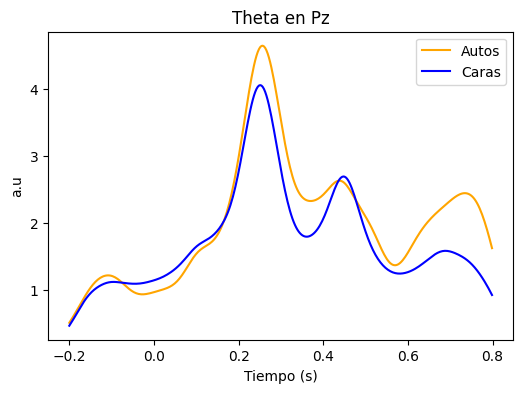

In [61]:
ind_freq=np.where(power_car.freqs<8)[0]
ind_t_base = np.where(power_car.times<0)[0][-1]
tiempo_freq=power_car.times
base_car=np.mean(power_car.get_data()[ch_interest,ind_freq,:ind_t_base])
base_face=np.mean(power_face.get_data()[ch_interest,ind_freq,:ind_t_base])

Pz_power_car= np.mean(power_car.get_data()[ch_interest,ind_freq,:],axis=0)/base_car
Pz_power_face= np.mean(power_face.get_data()[ch_interest,ind_freq,:],axis=0)/base_face

fig=plt.figure(figsize=(6,4))
plt.plot(tiempo_freq,Pz_power_car,c='orange',label='Autos')
plt.plot(tiempo_freq,Pz_power_face,c='b',label='Caras')
plt.xlabel('Tiempo (s)')
plt.ylabel('a.u')
plt.title('Theta en Pz' )
plt.legend()